In [35]:
import csv
from itertools import combinations
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import folium
from folium import GeoJson
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import networkx as nx
import folium
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import random
from pyproj import Proj, transform
import plotly.graph_objects as go
# from fuzzywuzzy import process
from shapely.geometry import LineString
import math
import networkx as nx
from shapely.geometry import LineString
from shapely import simplify
import math
import networkx as nx
import folium
import geopandas as gpd
import os

# **Parser for the FAF & FTOT data**

- Where are the original links of the FAF data files?
    - https://faf.ornl.gov/faf5/data/download_files/FAF5.6.1.zip
        - FAF5_metadata.xlsx
        - FAF5.6.1.csv


In [36]:
## global project data directory
# shared data root for the project
DATA_ROOT = '/home/recoil/shared_space/'

# Config input files

In [37]:
faf_meta_file = DATA_ROOT + 'recoil_data/FAF/FAF5_metadata.xlsx'

faf_data_file = DATA_ROOT + 'recoil_data/FAF/FAF5.6.csv' # version 5.6
# faf_data_file = DATA_ROOT + 'recoil_data/FAF/FAF5.6.1.csv' # version 5.6.1

master_cities_file = DATA_ROOT + 'recoil_data/FAF/MASTER_CITIES.csv'


# direct URLs
# FAF
faf_meta_url = 'https://recoil.ise.utk.edu/data/FAF/FAF5_metadata.xlsx'
faf_data_url = 'https://recoil.ise.utk.edu/data/FAF/FAF5.6.1.csv'
master_cities_url = 'https://recoil.ise.utk.edu/data/FAF/MASTER_CITIES.csv'

#FTOT
railnetwork_shape_url = 'https://recoil.ise.utk.edu/data/FAF/RailNetwork_ExportFeatures.shp'
roadnetwork_shape_url = 'https://recoil.ise.utk.edu/data/FAF/RoadNetwork_ExportFeatures.shp'
waternetwork_shape_url = 'https://recoil.ise.utk.edu/data/FAF/WaterNetwork_ExportFeatures.shp'


# Explore FAF meta data

- Available tabs from FAF5_metadata.xlsx
- 

## domestic zones

In [38]:
# try to read directly from online url
faf_meta_url = 'https://recoil.ise.utk.edu/data/FAF/FAF5_metadata.xlsx'

df_faf_meta_zone_dms = pd.read_excel(faf_meta_url, sheet_name='FAF Zone (Domestic)')
df_faf_meta_zone_dms

,Numeric Label,Short Description,Long Description
0,11,Birmingham AL,"Birmingham-Hoover-Talladega, AL CFS Area"
1,12,Mobile AL,"Mobile-Daphne-Fairhope, AL CFS Area"
2,19,Rest of AL,Remainder of Alabama
3,20,Alaska,Alaska
4,41,Phoenix AZ,"Phoenix-Mesa-Scottsdale, AZ CFS Area"
...,...,...,...
127,539,Rest of WA,Remainder of Washington
128,540,West Virginia,West Virginia
129,551,Milwaukee WI,"Milwaukee-Racine-Waukesha, WI CFS Area"
130,559,Rest of WI,Remainder of Wisconsin_x000D_


In [39]:
# domestic zones
df_faf_meta_zone_dms = pd.read_excel(faf_meta_file, sheet_name='FAF Zone (Domestic)')
df_faf_meta_zone_dms

,Numeric Label,Short Description,Long Description
0,11,Birmingham AL,"Birmingham-Hoover-Talladega, AL CFS Area"
1,12,Mobile AL,"Mobile-Daphne-Fairhope, AL CFS Area"
2,19,Rest of AL,Remainder of Alabama
3,20,Alaska,Alaska
4,41,Phoenix AZ,"Phoenix-Mesa-Scottsdale, AZ CFS Area"
...,...,...,...
127,539,Rest of WA,Remainder of Washington
128,540,West Virginia,West Virginia
129,551,Milwaukee WI,"Milwaukee-Racine-Waukesha, WI CFS Area"
130,559,Rest of WI,Remainder of Wisconsin_x000D_


In [40]:
# show a few that with `Rest of ..`
df_faf_meta_zone_dms.iloc[18:25]


,Numeric Label,Short Description,Long Description
18,99,Rest of CT,Remainder of Connecticut
19,101,Philadelphia PA-NJ-DE-MD (DE Part),"Philadelphia-Reading-Camden, PA-NJ-DE-MD CFS ..."
20,109,Rest of DE,Remainder of Delaware
21,111,Washington DC-VA-MD-WV (DC Part),"Washington-Arlington-Alexandria, DC-VA-MD-WV ..."
22,121,Jacksonville FL-GA CFS Area (FL Part),"Jacksonville-St. Marys-Palatka, FL-GA CFS Are..."
23,122,Miami FL,"Miami-Fort Lauderdale-Port St. Lucie, FL CFS ..."
24,123,Orlando FL,"Orlando-Deltona-Daytona Beach, FL CFS Area"


In [41]:
# mode
df_faf_meta_mode = pd.read_excel(faf_meta_file, sheet_name='Mode')
df_faf_meta_mode

,Numeric Label,Description
0,1,Truck
1,2,Rail
2,3,Water
3,4,Air (include truck-air)
4,5,Multiple modes & mail
5,6,Pipeline
6,7,Other and unknown
7,8,No domestic mode


# Main FAF data

In [42]:
chunksize = 50000  # Define the size of each chunk

# Create an empty list to store chunks
chunks = []

# Iterate over the file in chunks
for chunk in pd.read_csv(faf_data_file, chunksize=chunksize):
    # Do something with each chunk
    chunks.append(chunk)

# Concatenate all chunks if necessary
df_faf = pd.concat(chunks)

In [43]:
df_faf.shape

(2506384, 51)

In [44]:
df_faf.head(3)

,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,dist_band,...,tmiles_2019,tmiles_2020,tmiles_2021,tmiles_2022,tmiles_2025,tmiles_2030,tmiles_2035,tmiles_2040,tmiles_2045,tmiles_2050
0,NaN,11,11,NaN,NaN,1,NaN,1,1,1,...,3.351765,3.375547,3.482383,3.502040,4.364371,5.327137,6.342501,7.763605,9.571647,11.343818
1,NaN,11,19,NaN,NaN,1,NaN,1,1,2,...,50.646235,51.005589,52.619906,52.916934,62.052489,72.493059,82.113979,96.869428,116.602924,134.683927
2,NaN,11,129,NaN,NaN,1,NaN,1,1,3,...,0.468714,0.472040,0.486980,0.489729,0.486727,0.533539,0.564126,0.638719,0.750361,0.844720


In [45]:
df_faf.tail(3)

,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,dist_band,...,tmiles_2019,tmiles_2020,tmiles_2021,tmiles_2022,tmiles_2025,tmiles_2030,tmiles_2035,tmiles_2040,tmiles_2045,tmiles_2050
2506381,NaN,559,451,808.0,NaN,2,3.0,43,3,6,...,0.0,0.0,0.0,0.000255,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2506382,NaN,559,512,808.0,NaN,1,3.0,43,3,6,...,0.0,0.0,0.0,0.002010,0.000578,0.000698,0.000818,0.000963,0.001139,0.00135
2506383,NaN,560,151,808.0,NaN,7,7.0,43,3,8,...,0.0,0.0,0.0,0.000000,23.813470,27.408215,31.135441,35.549942,40.781738,46.98884


### domestic data only

In [46]:
# keep those fr_orig fr_inmode fr_dest etc. are NaN. i.e., focus on demestic freight only
df_faf_dms = df_faf[df_faf[['fr_orig', 'fr_inmode', 'fr_dest']].isna().all(axis=1)]

In [47]:
df_faf_dms

,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,dist_band,...,tmiles_2019,tmiles_2020,tmiles_2021,tmiles_2022,tmiles_2025,tmiles_2030,tmiles_2035,tmiles_2040,tmiles_2045,tmiles_2050
0,NaN,11,11,NaN,NaN,1,NaN,1,1,1,...,3.351765,3.375547,3.482383,3.502040,4.364371,5.327137,6.342501,7.763605,9.571647,11.343818
1,NaN,11,19,NaN,NaN,1,NaN,1,1,2,...,50.646235,51.005589,52.619906,52.916934,62.052489,72.493059,82.113979,96.869428,116.602924,134.683927
2,NaN,11,129,NaN,NaN,1,NaN,1,1,3,...,0.468714,0.472040,0.486980,0.489729,0.486727,0.533539,0.564126,0.638719,0.750361,0.844720
3,NaN,11,131,NaN,NaN,1,NaN,1,1,2,...,2.267241,2.283328,2.355595,2.368892,2.549854,3.018065,3.155784,3.394250,3.850035,4.178881
4,NaN,11,139,NaN,NaN,1,NaN,1,1,2,...,1.327792,1.337213,1.379536,1.387323,1.554450,1.863748,1.969298,2.141527,2.456208,2.683008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522747,NaN,560,551,NaN,NaN,1,NaN,43,1,6,...,0.014915,0.014802,0.014816,0.014521,0.017740,0.020190,0.022923,0.026069,0.030231,0.033362
522748,NaN,560,551,NaN,NaN,5,NaN,43,1,6,...,0.000053,0.000052,0.000052,0.000051,0.000063,0.000071,0.000082,0.000092,0.000107,0.000118
522749,NaN,560,559,NaN,NaN,1,NaN,43,1,5,...,0.140537,0.139474,0.139603,0.136822,0.166041,0.187244,0.210719,0.237225,0.272736,0.300974
522750,NaN,560,560,NaN,NaN,1,NaN,43,1,2,...,27.543784,27.335445,27.360714,26.815749,30.199037,33.626601,37.341173,41.412250,46.898192,51.754010


In [48]:
df_faf_dms.shape

(522752, 51)

### selected columns for dms

In [49]:
# filter selected columns
columns_to_keep = ['dms_orig', 'dms_dest', 'dms_mode'] + [col for col in df_faf.columns if col.startswith('tons_')]

In [50]:
columns_to_keep

['dms_orig',
 'dms_dest',
 'dms_mode',
 'tons_2017',
 'tons_2018',
 'tons_2019',
 'tons_2020',
 'tons_2021',
 'tons_2022',
 'tons_2025',
 'tons_2030',
 'tons_2035',
 'tons_2040',
 'tons_2045',
 'tons_2050']

In [51]:
df_faf_dms_filtered = df_faf_dms[columns_to_keep] # only keep selected columns

In [52]:
df_faf_dms_filtered

,dms_orig,dms_dest,dms_mode,tons_2017,tons_2018,tons_2019,tons_2020,tons_2021,tons_2022,tons_2025,tons_2030,tons_2035,tons_2040,tons_2045,tons_2050
0,11,11,1,51.010231,51.863434,54.012407,54.395645,56.117256,56.434027,70.330154,85.844765,102.206970,125.107510,154.243420,182.801270
1,11,19,1,385.622345,392.072310,408.317910,411.215079,424.229954,426.624644,500.276920,584.450440,662.015810,780.976560,940.071110,1085.843000
2,11,129,1,1.360447,1.383202,1.440515,1.450736,1.496652,1.505100,1.495874,1.639743,1.733747,1.962994,2.306109,2.596105
3,11,131,1,12.489625,12.698528,13.224694,13.318528,13.740057,13.817617,14.873157,17.604208,18.407513,19.798471,22.457041,24.375181
4,11,139,1,5.134423,5.220302,5.436606,5.475181,5.648469,5.680354,6.364650,7.631062,8.063235,8.768422,10.056874,10.985498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522747,560,551,1,0.014969,0.015170,0.014913,0.014800,0.014814,0.014519,0.017738,0.020188,0.022921,0.026066,0.030228,0.033358
522748,560,551,5,0.000050,0.000051,0.000050,0.000049,0.000049,0.000048,0.000059,0.000067,0.000077,0.000087,0.000101,0.000111
522749,560,559,1,0.152565,0.154616,0.151996,0.150846,0.150986,0.147978,0.179580,0.202511,0.227900,0.256568,0.294974,0.325515
522750,560,560,1,170.264694,172.553093,169.629554,168.346488,168.502110,165.145920,185.982040,207.090840,229.967190,255.039090,288.824490,318.729250


### map mode

In [53]:
# self defined mapping dictionary
mode_mapping = {
    1: 'Road',
    2: 'Rail',
    3: 'Water',
    4: 'Air (include truck-air)',
    5: 'Multiple modes & mail',
    6: 'Pipeline',
    7: 'Other and unknown',
    8: 'No domestic mode'
}

In [54]:
# Step 1: Convert 'dms_mode' column to float, then object
df_faf_dms_filtered.loc[:,'dms_mode'] = df_faf_dms_filtered['dms_mode'].astype(float).astype(object)

# Step 2: Apply the mapping
df_faf_dms_filtered.loc[:,'dms_mode'] = df_faf_dms_filtered['dms_mode'].map(mode_mapping)


/tmp/ipykernel_322363/2946473907.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.0 1.0 1.0 ... 1.0 1.0 5.0]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_faf_dms_filtered.loc[:,'dms_mode'] = df_faf_dms_filtered['dms_mode'].astype(float).astype(object)


In [55]:
df_faf_dms_filtered

,dms_orig,dms_dest,dms_mode,tons_2017,tons_2018,tons_2019,tons_2020,tons_2021,tons_2022,tons_2025,tons_2030,tons_2035,tons_2040,tons_2045,tons_2050
0,11,11,Road,51.010231,51.863434,54.012407,54.395645,56.117256,56.434027,70.330154,85.844765,102.206970,125.107510,154.243420,182.801270
1,11,19,Road,385.622345,392.072310,408.317910,411.215079,424.229954,426.624644,500.276920,584.450440,662.015810,780.976560,940.071110,1085.843000
2,11,129,Road,1.360447,1.383202,1.440515,1.450736,1.496652,1.505100,1.495874,1.639743,1.733747,1.962994,2.306109,2.596105
3,11,131,Road,12.489625,12.698528,13.224694,13.318528,13.740057,13.817617,14.873157,17.604208,18.407513,19.798471,22.457041,24.375181
4,11,139,Road,5.134423,5.220302,5.436606,5.475181,5.648469,5.680354,6.364650,7.631062,8.063235,8.768422,10.056874,10.985498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522747,560,551,Road,0.014969,0.015170,0.014913,0.014800,0.014814,0.014519,0.017738,0.020188,0.022921,0.026066,0.030228,0.033358
522748,560,551,Multiple modes & mail,0.000050,0.000051,0.000050,0.000049,0.000049,0.000048,0.000059,0.000067,0.000077,0.000087,0.000101,0.000111
522749,560,559,Road,0.152565,0.154616,0.151996,0.150846,0.150986,0.147978,0.179580,0.202511,0.227900,0.256568,0.294974,0.325515
522750,560,560,Road,170.264694,172.553093,169.629554,168.346488,168.502110,165.145920,185.982040,207.090840,229.967190,255.039090,288.824490,318.729250


### only keep road, rail, and water

In [56]:
df_faf_dms_filtered_rrw = df_faf_dms_filtered[df_faf_dms_filtered['dms_mode'].isin(['Road', 'Rail', 'Water'])]


In [57]:
df_faf_dms_filtered_rrw

,dms_orig,dms_dest,dms_mode,tons_2017,tons_2018,tons_2019,tons_2020,tons_2021,tons_2022,tons_2025,tons_2030,tons_2035,tons_2040,tons_2045,tons_2050
0,11,11,Road,51.010231,51.863434,54.012407,54.395645,56.117256,56.434027,70.330154,85.844765,102.206970,125.107510,154.243420,182.801270
1,11,19,Road,385.622345,392.072310,408.317910,411.215079,424.229954,426.624644,500.276920,584.450440,662.015810,780.976560,940.071110,1085.843000
2,11,129,Road,1.360447,1.383202,1.440515,1.450736,1.496652,1.505100,1.495874,1.639743,1.733747,1.962994,2.306109,2.596105
3,11,131,Road,12.489625,12.698528,13.224694,13.318528,13.740057,13.817617,14.873157,17.604208,18.407513,19.798471,22.457041,24.375181
4,11,139,Road,5.134423,5.220302,5.436606,5.475181,5.648469,5.680354,6.364650,7.631062,8.063235,8.768422,10.056874,10.985498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522743,560,531,Road,0.290265,0.294166,0.289182,0.286995,0.287260,0.281539,0.313389,0.342924,0.377977,0.415008,0.466224,0.514497
522745,560,539,Road,0.296757,0.300745,0.295650,0.293414,0.293685,0.287835,0.316572,0.349810,0.386347,0.425795,0.479458,0.529101
522747,560,551,Road,0.014969,0.015170,0.014913,0.014800,0.014814,0.014519,0.017738,0.020188,0.022921,0.026066,0.030228,0.033358
522749,560,559,Road,0.152565,0.154616,0.151996,0.150846,0.150986,0.147978,0.179580,0.202511,0.227900,0.256568,0.294974,0.325515


**Prompt::**

```
I have a dataframe: df_faf_meta_zone_dms

sample data:

	Numeric Label	Short Description	Long Description
0	11	Birmingham AL	Birmingham-Hoover-Talladega, AL CFS Area
1	12	Mobile AL	Mobile-Daphne-Fairhope, AL CFS Area
2	19	Rest of AL	Remainder of Alabama


df_faf_dms_filtered_rrw

sample data:

dms_orig	dms_dest	dms_mode	tons_2017	tons_2018	tons_2019	tons_2020	tons_2021	tons_2022	tons_2025	tons_2030	tons_2035	tons_2040	tons_2045	tons_2050
0	11	11	Road	51.010231	51.863434	54.012407	54.395645	56.117256	56.434027	70.330154	85.844765	102.206970	125.107510	154.243420	182.801270
1	11	19	Road	385.622345	392.072310	408.317910	411.215079	424.229954	426.624644	500.276920	584.450440	662.015810	780.976560	940.071110	1085.843000

How to add a column to df_faf_dms_filtered_rrw for dms_orig and dms_dest and name them as dms_orig_text and dms_dest_text with the value from the Short Description in df_faf_meta_zone_dms?

```

In [58]:
# Merge to get 'dms_orig_text' by matching 'dms_orig' with 'Numeric Label'
df_faf_dms_filtered_rrw = df_faf_dms_filtered_rrw.merge(
    df_faf_meta_zone_dms[['Numeric Label', 'Short Description']], 
    left_on='dms_orig', 
    right_on='Numeric Label', 
    how='left'
).rename(columns={'Short Description': 'dms_orig_text'})

# Drop the extra 'Numeric Label' column (from merge)
df_faf_dms_filtered_rrw = df_faf_dms_filtered_rrw.drop(columns=['Numeric Label'])

# Merge again to get 'dms_dest_text' by matching 'dms_dest' with 'Numeric Label'
df_faf_dms_filtered_rrw = df_faf_dms_filtered_rrw.merge(
    df_faf_meta_zone_dms[['Numeric Label', 'Short Description']], 
    left_on='dms_dest', 
    right_on='Numeric Label', 
    how='left'
).rename(columns={'Short Description': 'dms_dest_text'})

# Drop the extra 'Numeric Label' column (from merge)
df_faf_dms_filtered_rrw = df_faf_dms_filtered_rrw.drop(columns=['Numeric Label'])


In [59]:
df_faf_dms_filtered_rrw

,dms_orig,dms_dest,dms_mode,tons_2017,tons_2018,tons_2019,tons_2020,tons_2021,tons_2022,tons_2025,tons_2030,tons_2035,tons_2040,tons_2045,tons_2050,dms_orig_text,dms_dest_text
0,11,11,Road,51.010231,51.863434,54.012407,54.395645,56.117256,56.434027,70.330154,85.844765,102.206970,125.107510,154.243420,182.801270,Birmingham AL,Birmingham AL
1,11,19,Road,385.622345,392.072310,408.317910,411.215079,424.229954,426.624644,500.276920,584.450440,662.015810,780.976560,940.071110,1085.843000,Birmingham AL,Rest of AL
2,11,129,Road,1.360447,1.383202,1.440515,1.450736,1.496652,1.505100,1.495874,1.639743,1.733747,1.962994,2.306109,2.596105,Birmingham AL,Rest of FL
3,11,131,Road,12.489625,12.698528,13.224694,13.318528,13.740057,13.817617,14.873157,17.604208,18.407513,19.798471,22.457041,24.375181,Birmingham AL,Atlanta GA
4,11,139,Road,5.134423,5.220302,5.436606,5.475181,5.648469,5.680354,6.364650,7.631062,8.063235,8.768422,10.056874,10.985498,Birmingham AL,Rest of GA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289377,560,531,Road,0.290265,0.294166,0.289182,0.286995,0.287260,0.281539,0.313389,0.342924,0.377977,0.415008,0.466224,0.514497,Wyoming,Seattle WA
289378,560,539,Road,0.296757,0.300745,0.295650,0.293414,0.293685,0.287835,0.316572,0.349810,0.386347,0.425795,0.479458,0.529101,Wyoming,Rest of WA
289379,560,551,Road,0.014969,0.015170,0.014913,0.014800,0.014814,0.014519,0.017738,0.020188,0.022921,0.026066,0.030228,0.033358,Wyoming,Milwaukee WI
289380,560,559,Road,0.152565,0.154616,0.151996,0.150846,0.150986,0.147978,0.179580,0.202511,0.227900,0.256568,0.294974,0.325515,Wyoming,Rest of WI


In [60]:
df_faf_dms_filtered_rrw['dms_orig_text']

0         Birmingham AL
1         Birmingham AL
2         Birmingham AL
3         Birmingham AL
4         Birmingham AL
              ...      
289377          Wyoming
289378          Wyoming
289379          Wyoming
289380          Wyoming
289381          Wyoming
Name: dms_orig_text, Length: 289382, dtype: object

In [61]:
# Ensure both columns are of string type
df_faf_dms_filtered_rrw['dms_orig_text'] = df_faf_dms_filtered_rrw['dms_orig_text'].astype(str)
df_faf_dms_filtered_rrw['dms_dest_text'] = df_faf_dms_filtered_rrw['dms_dest_text'].astype(str)

# Filter rows where 'dms_orig_text' or 'dms_dest_text' do NOT start with 'Rest of'
df_faf_dms_filtered_rrw = df_faf_dms_filtered_rrw[
    ~df_faf_dms_filtered_rrw['dms_orig_text'].str.startswith('Rest of') & 
    ~df_faf_dms_filtered_rrw['dms_dest_text'].str.startswith('Rest of')
]


In [62]:
df_faf_dms_filtered_rrw

,dms_orig,dms_dest,dms_mode,tons_2017,tons_2018,tons_2019,tons_2020,tons_2021,tons_2022,tons_2025,tons_2030,tons_2035,tons_2040,tons_2045,tons_2050,dms_orig_text,dms_dest_text
0,11,11,Road,51.010231,51.863434,54.012407,54.395645,56.117256,56.434027,70.330154,85.844765,102.206970,125.107510,154.243420,182.801270,Birmingham AL,Birmingham AL
3,11,131,Road,12.489625,12.698528,13.224694,13.318528,13.740057,13.817617,14.873157,17.604208,18.407513,19.798471,22.457041,24.375181,Birmingham AL,Atlanta GA
5,11,280,Road,135.075287,137.334572,143.025059,144.039876,148.598709,149.437518,165.958080,191.444790,216.874650,257.073850,313.162720,364.250370,Birmingham AL,Mississippi
7,11,472,Road,1.044785,1.062260,1.106275,1.114125,1.149386,1.155874,1.376579,1.513114,1.591455,1.771465,2.095484,2.370462,Birmingham AL,Nashville TN
9,12,12,Road,13.523384,13.749578,14.319294,14.420895,14.877314,14.961293,17.959209,21.028540,23.849453,27.819315,32.556034,36.784824,Mobile AL,Mobile AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289374,560,512,Road,0.018683,0.018934,0.018613,0.018473,0.018490,0.018121,0.021617,0.024273,0.027254,0.030509,0.034899,0.038513,Wyoming,Virginia Beach-Norfolk VA-NC (VA Part)
289375,560,513,Road,0.016696,0.016920,0.016634,0.016508,0.016523,0.016194,0.019928,0.022417,0.025202,0.028234,0.032282,0.035625,Wyoming,Washington DC-VA-MD-WV (VA Part)
289377,560,531,Road,0.290265,0.294166,0.289182,0.286995,0.287260,0.281539,0.313389,0.342924,0.377977,0.415008,0.466224,0.514497,Wyoming,Seattle WA
289379,560,551,Road,0.014969,0.015170,0.014913,0.014800,0.014814,0.014519,0.017738,0.020188,0.022921,0.026066,0.030228,0.033358,Wyoming,Milwaukee WI


In [63]:
#THIS IS AN EXTERNAL PROCESS:

In [64]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

# Sample DataFrame (replace this with your actual data loading)
data = df_faf_dms_filtered_rrw
df = pd.DataFrame(data)

# Step 1: Extract the last two columns and drop duplicates
df_unique = df[['dms_orig_text', 'dms_dest_text']].drop_duplicates()

# Step 2: Create a new column called 'dms_orig' (if needed)
df_unique['dms_orig'] = df_unique['dms_orig_text']

df_unique.drop(columns=['dms_orig_text','dms_dest_text'],inplace=True)

In [65]:
df_unique.drop_duplicates(subset=['dms_orig'],inplace=True)

In [66]:
pd.set_option('display.max_rows', None)  # This will allow you to see all rows
df_unique['dms_orig']

0                                  Birmingham AL
9                                      Mobile AL
34                                        Alaska
35                                    Phoenix AZ
38                                     Tucson AZ
44                                      Arkansas
54                                Los Angeles CA
73                                 Sacramento CA
77                                  San Diego CA
81                              San Francisco CA
90                                     Fresno CA
100                                    Denver CO
109                                  Hartford CT
118               New York NY-NJ-CT-PA (CT Part)
130       Jacksonville FL-GA  CFS Area (FL Part)
135                                     Miami FL
137                                   Orlando FL
141                                     Tampa FL
157                                   Atlanta GA
199                                  Savannah GA
209                 

In [67]:
pd.set_option('display.max_rows', 30)  # This will allow you to see all rows

#CHAT GPT:  pelase add the coordinates as two columns end up with these three columns
# 'dms_orig','latitude_dms_orig','longitude_dms_orig' please make sure those are the actual coodinates

In [165]:

# Dictionary containing locations and their coordinates
coordinates = {
    "Birmingham AL": (33.51861, -86.81041),
    "Mobile AL": (30.69543, -88.03987),
    "Alaska": (61.37072, -152.40438),
    "Phoenix AZ": (33.44841, -112.07401),
    "Tucson AZ": (32.22266, -110.97473),
    "Arkansas": (34.79991, -92.14848),
    "Los Angeles CA": (34.05225, -118.24372),
    "Sacramento CA": (38.58161, -121.49445),
    "San Diego CA": (32.71572, -117.16112),
    "San Francisco CA": (37.77491, -122.41945),
    "Fresno CA": (36.73782, -119.78713),
    "Denver CO": (39.73925, -104.99034),
    "Hartford CT": (41.76584, -72.67344),
    "New York NY-NJ-CT-PA (CT Part)": (41.76403, -72.68512),
    "Jacksonville FL-GA  CFS Area (FL Part)": (30.33224, -81.65572),
    "Miami FL": (25.76173, -80.19185),
    "Orlando FL": (28.53834, -81.37926),
    "Tampa FL": (27.94753, -82.45847),
    "Atlanta GA": (33.74904, -84.38804),
    "Savannah GA": (32.08364, -81.09984),
    "Honolulu HI": (21.30692, -157.85834),
    "Idaho": (44.06825, -114.74202),
    "Chicago IL-IN-WI (IL Part)": (41.87812, -87.62984),
    "St. Louis MO-IL (IL Part)": (38.62705, -90.19942),
    "Chicago IL-IN-WI (IN Part)": (39.76845, -86.15802),
    "Indianapolis IN": (39.76841, -86.15803),
    "Fort Wayne IN": (41.07934, -85.13944),
    "Iowa": (41.87805, -93.09775),
    "Kansas City MO-KS (KS Part)": (39.09974, -94.57867),
    "Kansas City MO-KS (MO Part)": (39.09995, -94.57895),
    "Wichita KS": (37.68726, -97.33014),
    "Cincinnati OH-KY-IN (KY Part)": (39.10314, -84.51207),
    "Louisville KY-IN (KY Part)": (38.25443, -85.75966),
    "Baton Rouge LA": (30.45154, -91.18719),
    "Lake Charles-Jennings LA": (30.22667, -93.21749),
    "New Orleans LA-MS (LA Part)": (29.95115, -90.07155),
    "Maine": (45.36736, -69.44558),
    "Baltimore MD": (39.29041, -76.61225),
    "Boston MA-RI-NH-CT (MA Part)": (42.36013, -71.05892),
    "Detroit MI": (42.33142, -83.04587),
    "Grand Rapids MI": (42.96341, -85.66854),
    "Minneapolis-St. Paul MN-WI (MN Part)": (44.97781, -93.26504),
    "Mississippi": (32.35472, -89.39851),
    "St. Louis MO-IL (MO Part)": (38.62701, -90.19945),
    "Montana": (46.87974, -110.36267),
    "Omaha NE-IA (NE Part)": (41.25658, -95.93456),
    "Las Vegas NV-AZ (NV Part)": (36.16993, -115.13982),
    "Boston MA-RI-NH-CT (NH Part)": (43.19394, -71.57248),
    "New York NY-NJ-CT-PA (NJ Part)": (40.05837, -74.40578),
    "Philadelphia PA-NJ-DE-MD (NJ Part)": (40.01712, -74.22727),
    "New Mexico": (34.84053, -106.24849),
    "New York NY-NJ-CT-PA (NY Part)": (40.71283, -74.00603),
    "Rochester NY": (43.16102, -77.61091),
    "Charlotte NC-SC (NC Part)": (35.22711, -80.84314),
    "Greensboro--Winston-Salem--High Point NC": (36.09996, -80.24421),
    "Raleigh-Durham NC": (35.77965, -78.63829),
    "North Dakota": (47.55154, -101.00203),
    "Cincinnati OH-KY-IN (OH Part)": (39.10316, -84.51208),
    "Cleveland OH": (41.49953, -81.69547),
    "Columbus OH": (39.96125, -82.99882),
    "Dayton OH": (39.75895, -84.19166),
    "Oklahoma City OK": (35.46763, -97.51643),
    "Tulsa OK": (36.15402, -95.99282),
    "Portland OR-WA (OR Part)": (45.51552, -122.67932),
    "Philadelphia PA-NJ-DE-MD (PA Part)": (39.95263, -75.16528),
    "Philadelphia PA-NJ-DE-MD (DE Part)": (39.73345, -75.52993),
    "Pittsburgh PA-OH-WV (PA Part)": (40.44063, -79.99594),
    "New York NY-NJ-CT-PA (PA Part)": (40.71284, -74.00605),
    "Boston MA-RI-NH-CT (RI Part)": (41.58012, -71.47742),
    "Charleston SC": (32.77654, -79.93204),
    "Greenville SC": (34.85263, -82.39406),
    "South Dakota": (44.29983, -99.42383),
    "Memphis TN-MS-AR (TN Part)": (35.14951, -90.04905),
    "Nashville TN": (36.16273, -86.78166),
    "Knoxville TN": (35.96058, -83.92073),
    "Austin TX": (30.26725, -97.74315),
    "Beaumont TX": (30.08029, -94.12664),
    "Corpus Christi TX": (27.80064, -97.39634),
    "Dallas-Fort Worth TX-OK (TX Part)": (32.77676, -96.79704),
    "El Paso TX-NM (TX Part)": (31.76193, -106.48501),
    "Houston TX": (29.76046, -95.36976),
    "Laredo TX": (27.50352, -99.50758),
    "San Antonio TX": (29.42412, -98.49363),
    "Salt Lake City UT": (40.76083, -111.89105),
    "Vermont": (44.55823, -72.57707),
    "Richmond VA": (37.54073, -77.43604),
    "Virginia Beach-Norfolk VA-NC (VA Part)": (36.85294, -75.97803),
    "Washington DC-VA-MD-WV (VA Part)": (38.90724, -77.03692),
    "Washington DC-VA-MD-WV (DC Part)": (38.89514, -77.03641),
    "Seattle WA": (47.60625, -122.33214),
    "Portland OR-WA (WA Part)": (45.51556, -122.67936),
    "West Virginia": (38.59768, -80.45492),
    "Wyoming": (43.07592, -107.29033),
    "Milwaukee WI": (43.03895, -87.90652),
    "Washington DC-VA-MD-WV (MD Part)": (39.04584, -76.64131),
    "Buffalo NY  CFS Area": (42.88643, -78.87847),
    "Albany NY  CFS Area": (42.65263, -73.75629),
}


# Convert the dictionary to a DataFrame
df_coordinates = pd.DataFrame.from_dict(coordinates, orient='index', columns=['Latitude', 'Longitude'])

# Reset the index to have a more readable DataFrame
df_coordinates.reset_index(inplace=True)
df_coordinates.rename(columns={'index': 'Location'}, inplace=True)

# Display the DataFrame
print(df_coordinates)


                            Location  Latitude  Longitude
0                      Birmingham AL  33.51861  -86.81041
1                          Mobile AL  30.69543  -88.03987
2                             Alaska  61.37072 -152.40438
3                         Phoenix AZ  33.44841 -112.07401
4                          Tucson AZ  32.22266 -110.97473
..                               ...       ...        ...
92                           Wyoming  43.07592 -107.29033
93                      Milwaukee WI  43.03895  -87.90652
94  Washington DC-VA-MD-WV (MD Part)  39.04584  -76.64131
95              Buffalo NY  CFS Area  42.88643  -78.87847
96               Albany NY  CFS Area  42.65263  -73.75629

[97 rows x 3 columns]


In [166]:
df_coordinates.columns=['dms_orig','latitude_dms_orig','longitude_dms_orig']

In [167]:
df_coordinates

,dms_orig,latitude_dms_orig,longitude_dms_orig
0,Birmingham AL,33.51861,-86.81041
1,Mobile AL,30.69543,-88.03987
2,Alaska,61.37072,-152.40438
3,Phoenix AZ,33.44841,-112.07401
4,Tucson AZ,32.22266,-110.97473
...,...,...,...
92,Wyoming,43.07592,-107.29033
93,Milwaukee WI,43.03895,-87.90652
94,Washington DC-VA-MD-WV (MD Part),39.04584,-76.64131
95,Buffalo NY CFS Area,42.88643,-78.87847


In [168]:
# df_coordinates.to_csv('../_tmp/MASTER_CITIES.csv')

In [169]:
MASTER_CITIES=df_coordinates

# FTOT PROCESSING

In [73]:
os.chdir('/home/recoil/shared_space/recoil_data/raw_data')

In [74]:

# Input shapefile
input_file = "RailNetwork_ExportFeatures.shp"
# Output GeoJSON file
output_file = "RailNetwork_ExportFeatures.geojson"
# Read the shapefile using GeoPandas
gdf = gpd.read_file(input_file)
# Save GeoJSON
gdf.to_file(output_file, driver="GeoJSON")

In [75]:

# Input shapefile
input_file = "RoadNetwork_ExportFeatures.shp"
# Output GeoJSON file
output_file = "RoadNetwork_ExportFeatures.geojson"
# Read the shapefile using GeoPandas
gdf = gpd.read_file(input_file)
# Save GeoJSON
gdf.to_file(output_file, driver="GeoJSON")


In [76]:
# Input shapefile
input_file = "WaterNetwork_ExportFeatures.shp"
# Output GeoJSON file
output_file = "WaterNetwork_ExportFeatures.geojson"
# Read the shapefile using GeoPandas
gdf = gpd.read_file(input_file)
# Save GeoJSON
gdf.to_file(output_file, driver="GeoJSON")

# Transforming

In [77]:
DATA_ROOT='/home/recoil/shared_space/'

In [78]:
output_file=DATA_ROOT+'recoil_data/raw_data/RailNetwork_ExportFeatures.geojson'

In [79]:
gdf = gpd.read_file(output_file)
print(gdf.shape)

(22389, 11)


In [80]:
# Define the target CRS (WGS84, EPSG:4326)
#Transform all geometries in an active geometry column to a different coordinate reference system.
#https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_crs.html
target_crs = 'EPSG:4326' # coordinate reference system.

# Convert the GeoDataFrame to the target CRS
gdf[target_crs] = gdf.to_crs(target_crs)['geometry']


   Name                       Link_Type  Dir_Flag  Volume  Capacity  VCR  \
0  ACEX  4: Class 1 Rights non-STRACNET         0     0.0       0.0  0.0   
1   ALS  4: Class 1 Rights non-STRACNET         0     0.0     600.0  0.0   
2   ALS  4: Class 1 Rights non-STRACNET         0     0.0     600.0  0.0   
3   ALS  4: Class 1 Rights non-STRACNET         0     0.0     600.0  0.0   
4    AM  4: Class 1 Rights non-STRACNET         0     0.0     600.0  0.0   

   Artificial  Shape_Leng Mode_Type    Length  \
0           0  610.913717      rail  0.379603   
1           0  116.214450      rail  0.072212   
2           0  228.146527      rail  0.141763   
3           0  323.384390      rail  0.200941   
4           0  518.217930      rail  0.322005   

                                            geometry  \
0  LINESTRING (-2181490.871 190275.547, -2181497....   
1  LINESTRING (508036.049 -29506.068, 508040.415 ...   
2  LINESTRING (508078.740 -29223.481, 508108.279 ...   
3  LINESTRING (508112.93

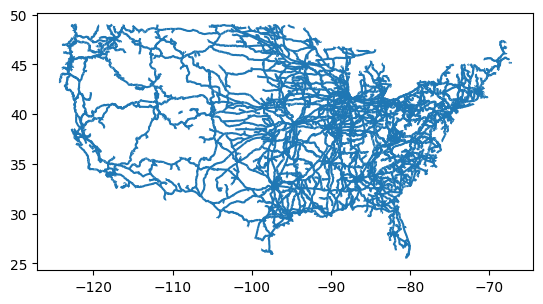

In [81]:
# Create a GeoDataFrame from the data
rail = gpd.GeoDataFrame(gdf, geometry='EPSG:4326')
print(rail.head())
# Plot the GeoDataFrame
fig, ax = plt.subplots()
rail.plot(ax=ax)
plt.show()

In [82]:
output_file=DATA_ROOT+'recoil_data/raw_data/WaterNetwork_ExportFeatures.geojson'

In [83]:
gdf = gpd.read_file(output_file)
print(gdf.shape)

(6175, 13)


In [84]:
# Define the target CRS (WGS84, EPSG:4326)
target_crs = 'EPSG:4326'

# Convert the GeoDataFrame to the target CRS
gdf[target_crs] = gdf.to_crs(target_crs)['geometry']


# Print the updated GeoDataFrame
gdf.columns

Index(['Name', 'Link_Type', 'Dir_Flag', 'Volume', 'Capacity', 'VCR',
       'Artificial', 'Mode_Type', 'ORIG_FID', 'ORIG_SEQ', 'Shape_Leng',
       'Length', 'geometry', 'EPSG:4326'],
      dtype='object')

                 Name      Link_Type  Dir_Flag  Volume  Capacity  VCR  \
6170  YAZOO RIVER, MS   4: No Volume         0     0.0       0.0  0.0   
6171   YORK RIVER, VA  3: Low Volume         0     0.0       0.0  0.0   
6172   YORK RIVER, VA  3: Low Volume         0     0.0       0.0  0.0   
6173   YORK RIVER, VA  3: Low Volume         0     0.0       0.0  0.0   
6174   YORK RIVER, VA  3: Low Volume         0     0.0       0.0  0.0   

      Artificial Mode_Type  ORIG_FID  ORIG_SEQ     Shape_Leng      Length  \
6170           0     water      6062         1  259003.627409  160.937071   
6171           0     water      6063         1   14985.630223    9.311620   
6172           0     water      6064         1   15456.209073    9.604024   
6173           0     water      6065         1   10922.080885    6.786653   
6174           0     water      6066         1   28655.148622   17.805448   

                                               geometry  \
6170  LINESTRING (539607.591 -584881.64

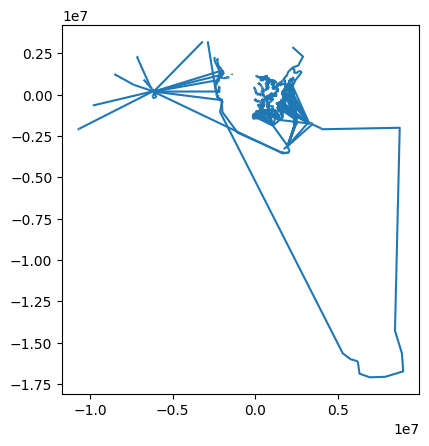

In [85]:
# Create a GeoDataFrame from the data
water = gpd.GeoDataFrame(gdf, geometry='geometry')
print(water.tail())
# Plot the GeoDataFrame
fig, ax = plt.subplots()
water.plot(ax=ax)
plt.show()

In [86]:
output_file=DATA_ROOT+'recoil_data/raw_data/RoadNetwork_ExportFeatures.geojson'

In [87]:
gdf = gpd.read_file(output_file)
# print(gdf.shape)

In [88]:
# Define the target CRS (WGS84, EPSG:4326)
target_crs = 'EPSG:4326'

# Convert the GeoDataFrame to the target CRS
gdf[target_crs] = gdf.to_crs(target_crs)['geometry']

# Print the updated GeoDataFrame


   Free_Speed  Name Link_Type  Dir_Flag  Urban_Rura  Limited_Ac  Volume  \
0          45  None      None         0           0           0     0.0   
1          45  None      None         0           0           0     0.0   
2          45  None      None         0           0           0     0.0   
3          45  None      None         0           0           0     0.0   
4          45  None      None         0           0           0     0.0   

   Capacity  VCR  Artificial  SHAPE_Leng Mode_Type    Length  \
0       0.0  0.0           0   29.558085      road  0.018367   
1       0.0  0.0           0  132.616081      road  0.082404   
2       0.0  0.0           0  475.141730      road  0.295239   
3       0.0  0.0           0  145.609211      road  0.090477   
4       0.0  0.0           0   78.027052      road  0.048484   

                                            geometry  \
0  LINESTRING (-770448.594 -81202.100, -770422.21...   
1  LINESTRING (-770422.212 -81215.430, -770302.89...

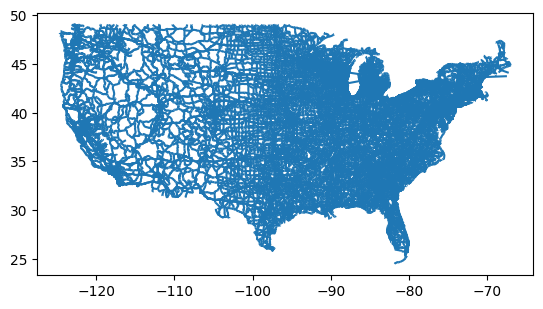

In [89]:
# Create a GeoDataFrame from the data
road = gpd.GeoDataFrame(gdf, geometry='EPSG:4326')
print(road.head())
# Plot the GeoDataFrame
fig, ax = plt.subplots()
road.plot(ax=ax)
plt.show()

In [90]:
rail=rail[['Mode_Type','Length','EPSG:4326']]
rail.tail()

,Mode_Type,Length,EPSG:4326
22384,rail,37.224060,"LINESTRING (-80.59676 41.06139, -80.59806 41.0..."
22385,rail,9.213283,"LINESTRING (-105.42946 48.79225, -105.42900 48..."
22386,rail,30.094301,"LINESTRING (-80.61694 36.50451, -80.61683 36.5..."
22387,rail,59.352077,"LINESTRING (-81.11607 36.17309, -81.11367 36.1..."
22388,rail,8.590879,"LINESTRING (-122.63334 41.70857, -122.63333 41..."


In [91]:
road=road[['Mode_Type','Length','EPSG:4326']]
road.tail()

,Mode_Type,Length,EPSG:4326
437357,road,7.531009,"LINESTRING (-122.68825 47.00914, -122.68848 47..."
437358,road,0.350505,"LINESTRING (-87.93994 41.89702, -87.93992 41.8..."
437359,road,1.548574,"LINESTRING (-87.93971 41.97603, -87.93971 41.9..."
437360,road,0.148462,"LINESTRING (-80.14230 26.01067, -80.14219 26.0..."
437361,road,4.935153,"LINESTRING (-117.11892 34.02759, -117.11887 34..."


In [92]:
water=water[['Mode_Type','Length','EPSG:4326']]
water.tail()
water.iloc[0,-2:]

Length                                             2328.432764
EPSG:4326    LINESTRING (-157.89248559806316 21.25332657248...
Name: 0, dtype: object

In [ ]:
# # Concatenate the subsets into a single GeoDataFrame
# combined_gdf = gpd.GeoDataFrame(pd.concat([rail, road, water], ignore_index=True))

# # Display the combined GeoDataFrame
# print(combined_gdf.head())

In [170]:
df_faf_dms_filtered_rrw

,dms_orig,dms_dest,dms_mode,tons_2017,tons_2018,tons_2019,tons_2020,tons_2021,tons_2022,tons_2025,tons_2030,tons_2035,tons_2040,tons_2045,tons_2050,dms_orig_text,dms_dest_text
0,11,11,Road,51.010231,51.863434,54.012407,54.395645,56.117256,56.434027,70.330154,85.844765,102.206970,125.107510,154.243420,182.801270,Birmingham AL,Birmingham AL
3,11,131,Road,12.489625,12.698528,13.224694,13.318528,13.740057,13.817617,14.873157,17.604208,18.407513,19.798471,22.457041,24.375181,Birmingham AL,Atlanta GA
5,11,280,Road,135.075287,137.334572,143.025059,144.039876,148.598709,149.437518,165.958080,191.444790,216.874650,257.073850,313.162720,364.250370,Birmingham AL,Mississippi
7,11,472,Road,1.044785,1.062260,1.106275,1.114125,1.149386,1.155874,1.376579,1.513114,1.591455,1.771465,2.095484,2.370462,Birmingham AL,Nashville TN
9,12,12,Road,13.523384,13.749578,14.319294,14.420895,14.877314,14.961293,17.959209,21.028540,23.849453,27.819315,32.556034,36.784824,Mobile AL,Mobile AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289374,560,512,Road,0.018683,0.018934,0.018613,0.018473,0.018490,0.018121,0.021617,0.024273,0.027254,0.030509,0.034899,0.038513,Wyoming,Virginia Beach-Norfolk VA-NC (VA Part)
289375,560,513,Road,0.016696,0.016920,0.016634,0.016508,0.016523,0.016194,0.019928,0.022417,0.025202,0.028234,0.032282,0.035625,Wyoming,Washington DC-VA-MD-WV (VA Part)
289377,560,531,Road,0.290265,0.294166,0.289182,0.286995,0.287260,0.281539,0.313389,0.342924,0.377977,0.415008,0.466224,0.514497,Wyoming,Seattle WA
289379,560,551,Road,0.014969,0.015170,0.014913,0.014800,0.014814,0.014519,0.017738,0.020188,0.022921,0.026066,0.030228,0.033358,Wyoming,Milwaukee WI


In [171]:
# Get unique values from each column and merge into a single list
unique_orig_text = df_faf_dms_filtered_rrw['dms_orig_text'].unique().tolist()
unique_dest_text = df_faf_dms_filtered_rrw['dms_dest_text'].unique().tolist()

# Merge the unique lists
merged_unique_list = list(set(unique_orig_text + unique_dest_text))

# Print the merged list
print(merged_unique_list)

['Corpus Christi TX', 'Washington DC-VA-MD-WV (DC Part)', 'Detroit MI', 'North Dakota', 'Mobile AL', 'Sacramento CA', 'San Diego CA', 'Tampa FL', 'Orlando FL', 'Cincinnati OH-KY-IN (KY Part)', 'Memphis TN-MS-AR (TN Part)', 'Honolulu HI', 'Omaha NE-IA (NE Part)', 'Washington DC-VA-MD-WV (VA Part)', 'Charlotte NC-SC (NC Part)', 'West Virginia', 'Mississippi', 'San Antonio TX', 'New York NY-NJ-CT-PA (CT Part)', 'Pittsburgh PA-OH-WV (PA Part)', 'Iowa', 'St. Louis MO-IL (IL Part)', 'New Mexico', 'Idaho', 'New York NY-NJ-CT-PA (NJ Part)', 'New York NY-NJ-CT-PA (NY Part)', 'St. Louis MO-IL (MO Part)', 'Knoxville TN', 'Atlanta GA', 'Alaska', 'Chicago IL-IN-WI (IL Part)', 'Savannah GA', 'Baltimore MD', 'Boston MA-RI-NH-CT (NH Part)', 'Kansas City MO-KS (KS Part)', 'Rochester NY', 'Hartford CT', 'Portland OR-WA (WA Part)', 'Maine', 'Dallas-Fort Worth TX-OK (TX Part)', 'Buffalo NY  CFS Area', 'Boston MA-RI-NH-CT (MA Part)', 'Houston TX', 'Louisville KY-IN (KY Part)', 'Indianapolis IN', 'Dayton OH

In [172]:
MASTER_CITIES


,dms_orig,latitude_dms_orig,longitude_dms_orig
0,Birmingham AL,33.51861,-86.81041
1,Mobile AL,30.69543,-88.03987
2,Alaska,61.37072,-152.40438
3,Phoenix AZ,33.44841,-112.07401
4,Tucson AZ,32.22266,-110.97473
...,...,...,...
92,Wyoming,43.07592,-107.29033
93,Milwaukee WI,43.03895,-87.90652
94,Washington DC-VA-MD-WV (MD Part),39.04584,-76.64131
95,Buffalo NY CFS Area,42.88643,-78.87847


In [173]:
MASTERUNIQUES=list(set(MASTER_CITIES.dms_orig))

In [174]:
# Convert lists to sets for easier comparison
set_merged = set(merged_unique_list)
set_master = set(MASTERUNIQUES)

# Find items in merged_unique_list not in MASTERUNIQUES
unique_to_merged = set_merged - set_master

# Find items in MASTERUNIQUES not in merged_unique_list
unique_to_master = set_master - set_merged

# Combine the unique items from both lists
different_items = unique_to_merged.union(unique_to_master)

print("Different items:", different_items)

Different items: set()


In [175]:
df_faf_dms_filtered_rrw

,dms_orig,dms_dest,dms_mode,tons_2017,tons_2018,tons_2019,tons_2020,tons_2021,tons_2022,tons_2025,tons_2030,tons_2035,tons_2040,tons_2045,tons_2050,dms_orig_text,dms_dest_text
0,11,11,Road,51.010231,51.863434,54.012407,54.395645,56.117256,56.434027,70.330154,85.844765,102.206970,125.107510,154.243420,182.801270,Birmingham AL,Birmingham AL
3,11,131,Road,12.489625,12.698528,13.224694,13.318528,13.740057,13.817617,14.873157,17.604208,18.407513,19.798471,22.457041,24.375181,Birmingham AL,Atlanta GA
5,11,280,Road,135.075287,137.334572,143.025059,144.039876,148.598709,149.437518,165.958080,191.444790,216.874650,257.073850,313.162720,364.250370,Birmingham AL,Mississippi
7,11,472,Road,1.044785,1.062260,1.106275,1.114125,1.149386,1.155874,1.376579,1.513114,1.591455,1.771465,2.095484,2.370462,Birmingham AL,Nashville TN
9,12,12,Road,13.523384,13.749578,14.319294,14.420895,14.877314,14.961293,17.959209,21.028540,23.849453,27.819315,32.556034,36.784824,Mobile AL,Mobile AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289374,560,512,Road,0.018683,0.018934,0.018613,0.018473,0.018490,0.018121,0.021617,0.024273,0.027254,0.030509,0.034899,0.038513,Wyoming,Virginia Beach-Norfolk VA-NC (VA Part)
289375,560,513,Road,0.016696,0.016920,0.016634,0.016508,0.016523,0.016194,0.019928,0.022417,0.025202,0.028234,0.032282,0.035625,Wyoming,Washington DC-VA-MD-WV (VA Part)
289377,560,531,Road,0.290265,0.294166,0.289182,0.286995,0.287260,0.281539,0.313389,0.342924,0.377977,0.415008,0.466224,0.514497,Wyoming,Seattle WA
289379,560,551,Road,0.014969,0.015170,0.014913,0.014800,0.014814,0.014519,0.017738,0.020188,0.022921,0.026066,0.030228,0.033358,Wyoming,Milwaukee WI


In [198]:
MASTER_CITIES_aux=MASTER_CITIES

# Combine latitude and longitude into a single 'coordinates' column
MASTER_CITIES_aux['coordinates'] = MASTER_CITIES_aux[['longitude_dms_orig','latitude_dms_orig']].apply(tuple, axis=1)

# Drop the individual latitude and longitude columns
MASTER_CITIES_aux = MASTER_CITIES_aux.drop(['latitude_dms_orig', 'longitude_dms_orig'], axis=1)

print(MASTER_CITIES_aux)

                            dms_orig             coordinates
0                      Birmingham AL   (-86.81041, 33.51861)
1                          Mobile AL   (-88.03987, 30.69543)
2                             Alaska  (-152.40438, 61.37072)
3                         Phoenix AZ  (-112.07401, 33.44841)
4                          Tucson AZ  (-110.97473, 32.22266)
..                               ...                     ...
92                           Wyoming  (-107.29033, 43.07592)
93                      Milwaukee WI   (-87.90652, 43.03895)
94  Washington DC-VA-MD-WV (MD Part)   (-76.64131, 39.04584)
95              Buffalo NY  CFS Area   (-78.87847, 42.88643)
96               Albany NY  CFS Area   (-73.75629, 42.65263)

[97 rows x 2 columns]


# SELECTED LOCATIONS

In [199]:
import pandas as pd



df1 = df_faf_dms_filtered_rrw
df2 = MASTER_CITIES_aux

# Merge for dms_orig_text to get orig_coordinates
merged_df = pd.merge(
    df1,
    df2,
    how='left',
    left_on='dms_orig_text',
    right_on='dms_orig'
)

# Rename the coordinates column for orig_coordinates
merged_df = merged_df.rename(columns={'coordinates': 'orig_coordinates'})

# Merge again for dms_dest_text to get dest_coordinates
merged_df = pd.merge(
    merged_df,
    df2,
    how='left',
    left_on='dms_dest_text',
    right_on='dms_orig'
)

# Rename the coordinates column for dest_coordinates
merged_df = merged_df.rename(columns={'coordinates': 'dest_coordinates'})

# Drop the redundant 'dms_orig' columns from the merges
merged_df = merged_df.drop(columns=['dms_orig_x', 'dms_orig_y'])

# Rename columns as specified
merged_df = merged_df.rename(
    columns={
        'dms_orig_text': 'dms_orig_string',
        'dms_dest_text': 'dms_dest_string'
    }
)

# Show the merged DataFrame
print(merged_df)

        dms_dest dms_mode   tons_2017   tons_2018   tons_2019   tons_2020  \
0             11     Road   51.010231   51.863434   54.012407   54.395645   
1            131     Road   12.489625   12.698528   13.224694   13.318528   
2            280     Road  135.075287  137.334572  143.025059  144.039876   
3            472     Road    1.044785    1.062260    1.106275    1.114125   
4             12     Road   13.523384   13.749578   14.319294   14.420895   
...          ...      ...         ...         ...         ...         ...   
151441       512     Road    0.018683    0.018934    0.018613    0.018473   
151442       513     Road    0.016696    0.016920    0.016634    0.016508   
151443       531     Road    0.290265    0.294166    0.289182    0.286995   
151444       551     Road    0.014969    0.015170    0.014913    0.014800   
151445       560     Road  170.264694  172.553093  169.629554  168.346488   

         tons_2021   tons_2022   tons_2025   tons_2030   tons_2035  \
0    

In [200]:
merged_df

,dms_dest,dms_mode,tons_2017,tons_2018,tons_2019,tons_2020,tons_2021,tons_2022,tons_2025,tons_2030,tons_2035,tons_2040,tons_2045,tons_2050,dms_orig_string,dms_dest_string,orig_coordinates,dms_orig,dest_coordinates
0,11,Road,51.010231,51.863434,54.012407,54.395645,56.117256,56.434027,70.330154,85.844765,102.206970,125.107510,154.243420,182.801270,Birmingham AL,Birmingham AL,"(-86.81041, 33.51861)",Birmingham AL,"(-86.81041, 33.51861)"
1,131,Road,12.489625,12.698528,13.224694,13.318528,13.740057,13.817617,14.873157,17.604208,18.407513,19.798471,22.457041,24.375181,Birmingham AL,Atlanta GA,"(-86.81041, 33.51861)",Atlanta GA,"(-84.38804, 33.74904)"
2,280,Road,135.075287,137.334572,143.025059,144.039876,148.598709,149.437518,165.958080,191.444790,216.874650,257.073850,313.162720,364.250370,Birmingham AL,Mississippi,"(-86.81041, 33.51861)",Mississippi,"(-89.39851, 32.35472)"
3,472,Road,1.044785,1.062260,1.106275,1.114125,1.149386,1.155874,1.376579,1.513114,1.591455,1.771465,2.095484,2.370462,Birmingham AL,Nashville TN,"(-86.81041, 33.51861)",Nashville TN,"(-86.78166, 36.16273)"
4,12,Road,13.523384,13.749578,14.319294,14.420895,14.877314,14.961293,17.959209,21.028540,23.849453,27.819315,32.556034,36.784824,Mobile AL,Mobile AL,"(-88.03987, 30.69543)",Mobile AL,"(-88.03987, 30.69543)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151441,512,Road,0.018683,0.018934,0.018613,0.018473,0.018490,0.018121,0.021617,0.024273,0.027254,0.030509,0.034899,0.038513,Wyoming,Virginia Beach-Norfolk VA-NC (VA Part),"(-107.29033, 43.07592)",Virginia Beach-Norfolk VA-NC (VA Part),"(-75.97803, 36.85294)"
151442,513,Road,0.016696,0.016920,0.016634,0.016508,0.016523,0.016194,0.019928,0.022417,0.025202,0.028234,0.032282,0.035625,Wyoming,Washington DC-VA-MD-WV (VA Part),"(-107.29033, 43.07592)",Washington DC-VA-MD-WV (VA Part),"(-77.03692, 38.90724)"
151443,531,Road,0.290265,0.294166,0.289182,0.286995,0.287260,0.281539,0.313389,0.342924,0.377977,0.415008,0.466224,0.514497,Wyoming,Seattle WA,"(-107.29033, 43.07592)",Seattle WA,"(-122.33214, 47.60625)"
151444,551,Road,0.014969,0.015170,0.014913,0.014800,0.014814,0.014519,0.017738,0.020188,0.022921,0.026066,0.030228,0.033358,Wyoming,Milwaukee WI,"(-107.29033, 43.07592)",Milwaukee WI,"(-87.90652, 43.03895)"


In [201]:
merged_df=merged_df[['dms_mode','dms_orig_string','dms_dest_string','orig_coordinates','dest_coordinates']]
merged_df.drop_duplicates(inplace=True)

/tmp/ipykernel_322363/3525380989.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.drop_duplicates(inplace=True)


In [202]:
# EVERYPOSSIBLE COMBINATIONS

In [203]:
merged_df

,dms_mode,dms_orig_string,dms_dest_string,orig_coordinates,dest_coordinates
0,Road,Birmingham AL,Birmingham AL,"(-86.81041, 33.51861)","(-86.81041, 33.51861)"
1,Road,Birmingham AL,Atlanta GA,"(-86.81041, 33.51861)","(-84.38804, 33.74904)"
2,Road,Birmingham AL,Mississippi,"(-86.81041, 33.51861)","(-89.39851, 32.35472)"
3,Road,Birmingham AL,Nashville TN,"(-86.81041, 33.51861)","(-86.78166, 36.16273)"
4,Road,Mobile AL,Mobile AL,"(-88.03987, 30.69543)","(-88.03987, 30.69543)"
...,...,...,...,...,...
148536,Rail,Cleveland OH,Columbus OH,"(-81.69547, 41.49953)","(-82.99882, 39.96125)"
149837,Rail,Knoxville TN,Los Angeles CA,"(-83.92073, 35.96058)","(-118.24372, 34.05225)"
149850,Rail,Knoxville TN,Tampa FL,"(-83.92073, 35.96058)","(-82.45847, 27.94753)"
149911,Rail,Knoxville TN,Dallas-Fort Worth TX-OK (TX Part),"(-83.92073, 35.96058)","(-96.79704, 32.77676)"


In [205]:
merged_df.dest_coordinates.value_counts()

dest_coordinates
(-118.24372, 34.05225)    156
(-95.36976, 29.76046)     153
(-87.62984, 41.87812)     153
(-84.38804, 33.74904)     141
(-90.07155, 29.95115)     139
                         ... 
(-71.47742, 41.58012)      94
(-72.67344, 41.76584)      94
(-77.03641, 38.89514)      94
(-157.85834, 21.30692)      8
(-152.40438, 61.37072)      7
Name: count, Length: 97, dtype: int64

In [206]:
# # Filter for rows where dms_dest_coordinates is (nan, nan)
# nan_nan_values = merged_df[merged_df['dms_dest_coordinates'].apply(lambda x: (np.isnan(x[0]) and np.isnan(x[1])) if isinstance(x, tuple) else False)]

# # Display the rows with dms_dest_coordinates as (nan, nan)
# print(nan_nan_values.dms_dest_string)

In [207]:
list(merged_df.columns)


['dms_mode',
 'dms_orig_string',
 'dms_dest_string',
 'orig_coordinates',
 'dest_coordinates']

In [208]:
merged_df.columns=['dms_mode',
 'dms_orig_string',
 'dms_dest_string',
 'dms_orig_coordinates',
 'dms_dest_coordinates']

# Direct Distances Calculator (GIS PATH and MILES)

# ROUTING ENGINE 

In [209]:
FAF_data2=merged_df.reset_index(drop=True)
FAF_data3=merged_df.reset_index(drop=True)

In [210]:
FAF_data2

,dms_mode,dms_orig_string,dms_dest_string,dms_orig_coordinates,dms_dest_coordinates
0,Road,Birmingham AL,Birmingham AL,"(-86.81041, 33.51861)","(-86.81041, 33.51861)"
1,Road,Birmingham AL,Atlanta GA,"(-86.81041, 33.51861)","(-84.38804, 33.74904)"
2,Road,Birmingham AL,Mississippi,"(-86.81041, 33.51861)","(-89.39851, 32.35472)"
3,Road,Birmingham AL,Nashville TN,"(-86.81041, 33.51861)","(-86.78166, 36.16273)"
4,Road,Mobile AL,Mobile AL,"(-88.03987, 30.69543)","(-88.03987, 30.69543)"
...,...,...,...,...,...
10667,Rail,Cleveland OH,Columbus OH,"(-81.69547, 41.49953)","(-82.99882, 39.96125)"
10668,Rail,Knoxville TN,Los Angeles CA,"(-83.92073, 35.96058)","(-118.24372, 34.05225)"
10669,Rail,Knoxville TN,Tampa FL,"(-83.92073, 35.96058)","(-82.45847, 27.94753)"
10670,Rail,Knoxville TN,Dallas-Fort Worth TX-OK (TX Part),"(-83.92073, 35.96058)","(-96.79704, 32.77676)"


In [211]:
import numpy as np

In [212]:
# Split the DataFrame into 10 parts
split_dfs = np.array_split(FAF_data2, 30)



/home/xli27/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [213]:
split_dfs

[    dms_mode                     dms_orig_string  \
 0       Road                       Birmingham AL   
 1       Road                       Birmingham AL   
 2       Road                       Birmingham AL   
 3       Road                       Birmingham AL   
 4       Road                           Mobile AL   
 ..       ...                                 ...   
 351     Road            Portland OR-WA (OR Part)   
 352     Road  Philadelphia PA-NJ-DE-MD (PA Part)   
 353     Road  Philadelphia PA-NJ-DE-MD (PA Part)   
 354     Road  Philadelphia PA-NJ-DE-MD (PA Part)   
 355     Road  Philadelphia PA-NJ-DE-MD (PA Part)   
 
                         dms_dest_string    dms_orig_coordinates  \
 0                         Birmingham AL   (-86.81041, 33.51861)   
 1                            Atlanta GA   (-86.81041, 33.51861)   
 2                           Mississippi   (-86.81041, 33.51861)   
 3                          Nashville TN   (-86.81041, 33.51861)   
 4                    

In [214]:


def calculate_distance(point1, point2):
    """Calculate the distance between two points using Haversine formula."""
    # Convert decimal degrees to radians
    lat1, lon1 = math.radians(point1[0]), math.radians(point1[1])
    lat2, lon2 = math.radians(point2[0]), math.radians(point2[1])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Radius of the Earth in meters
    R = 6371000

    # Calculate distance
    distance = R * c
    return distance

def find_nearest_node(graph, point):
    """Find the nearest node in the graph to the given point."""
    return min(graph.nodes, key=lambda node: calculate_distance(point, node))



    
    
    
   

In [215]:
jj=[i for i in range(0,30)]
jj
#ALL DATA IN TEN SPLITS

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29]

In [ ]:

for i in jj:
    # Initializing i and selecting the dataframe DO IT TIL 0-->9
    name = i
    df = split_dfs[name]
    
    # Dropping the specified columns in place
    # df.drop(columns=['level_0', 'index'], inplace=True)
    
    # Resetting the index in place
    df.reset_index(inplace=True, drop=True)
    print(name)
    # Printing the dataframe to check the changes
    print(df)
    
    
    
    
    G_road = nx.Graph()
    
    # Loop through 'rail' data and add edges to the graph
    for idx, row in road.iterrows():
        geom = row['EPSG:4326']
        if isinstance(geom, LineString):
            # Simplify the LineString geometry
            simplified_geom = simplify(geom, tolerance=0.9, preserve_topology=True)  # Adjust tolerance as needed
            
            nodes = list(simplified_geom.coords)
            for i in range(len(nodes) - 1):
                distance = calculate_distance(nodes[i], nodes[i + 1])
                G_road.add_edge(nodes[i], nodes[i + 1], weight=row.Length)
    
    
    
    G_rail = nx.Graph()
    
    # Loop through your data and add edges to the graph
    for idx, row in rail.iterrows():
        geom = row['EPSG:4326']
        if isinstance(geom, LineString):
            # Simplify the LineString geometry
            simplified_geom = simplify(geom, tolerance=0.9, preserve_topology=True)  # Adjust tolerance as needed
            
            nodes = list(simplified_geom.coords)
            for i in range(len(nodes) - 1):
                distance = calculate_distance(nodes[i], nodes[i + 1])
                G_rail.add_edge(nodes[i], nodes[i + 1], weight=row.Length)
    
    
    
    
    G_water = nx.Graph()
        
    # Loop through your data and add edges to the graph
    for idx, row in water.iterrows():
        geom = row['EPSG:4326']
        if isinstance(geom, LineString):
            # Simplify the LineString geometry
            simplified_geom = simplify(geom, tolerance=0.9, preserve_topology=True)  # Adjust tolerance as needed
            
            nodes = list(simplified_geom.coords)
            for i in range(len(nodes) - 1):
                distance = calculate_distance(nodes[i], nodes[i + 1])
                G_water.add_edge(nodes[i], nodes[i + 1], weight=row.Length)
    
    
    
    
    
    # df.drop(columns=['level_0','index'],axis=1,inplace=True).reset_index(inplace=True,drop=True)
    # print(df) .iloc[5:10,:]
    for idx_, step in enumerate(df.iterrows()):
        
        row = step[1]
        start_pos = row['dms_orig_coordinates']
        end_pos = row['dms_dest_coordinates']
        mode = row['dms_mode']
        # print(row)
        # input()
        
    
        #JUST A FEW JT
        # Print a message every 100 rows
        if idx_ % 100 == 0:
            print(f"Processing pair {idx_}")
            
    
        if mode=='Road':
            # Assuming 'road' is your GeoDataFrame containing road data
            G=G_road
        
        elif mode=='Rail':
            # Assuming 'road' is your GeoDataFrame containing road data
            G=G_rail
        
        elif mode=='Water':
            # Assuming 'road' is your GeoDataFrame containing road data
            G=G_water
    
        
        source_node = find_nearest_node(G, start_pos)
        target_node = find_nearest_node(G, end_pos)
    
        # Check if the source and target nodes are valid
        if source_node is None:
            source_node = start_pos
            G.add_node(source_node)
    
        if target_node is None:
            target_node = end_coords
    
        # Connect the source and target nodes to the closest nodes in the graph
        closest_source_node = find_nearest_node(G, source_node)
        closest_target_node = find_nearest_node(G, target_node)
    
        if closest_source_node is not None:
            G.add_edge(source_node, closest_source_node, weight=calculate_distance(source_node, closest_source_node))
    
        if closest_target_node is not None:
            G.add_edge(target_node, closest_target_node, weight=calculate_distance(target_node, closest_target_node))
    
        try:
            # Find the shortest path and calculate its length
            shortest_path = nx.shortest_path(G, source=source_node, target=target_node, weight='weight')
            path_length = sum(G[u][v]['weight'] for u, v in zip(shortest_path[:-1], shortest_path[1:]))
            df.at[idx_, 'distance_miles'] = path_length
            # print(shortest_path)
            df.at[idx_, 'path'] = str(shortest_path)
        except nx.NetworkXNoPath:
            df.at[idx_, 'distance_miles'] = 9999999.9
            df.at[idx_, 'path'] = str(list())
    
        
    df.to_csv(DATA_ROOT+'RECOIL_Data_Repo/_tmp/_new_intermodal_data_part_'+str(name)+'.csv',index=False)


    

Processing pair 300
12
    dms_mode   dms_orig_string                   dms_dest_string  \
0       Road  Oklahoma City OK          Portland OR-WA (OR Part)   
1       Road  Oklahoma City OK                        Seattle WA   
2       Road          Tulsa OK                     Birmingham AL   
3       Road          Tulsa OK                        Phoenix AZ   
4       Road          Tulsa OK                    Los Angeles CA   
..       ...               ...                               ...   
351     Road     West Virginia        Louisville KY-IN (KY Part)   
352     Road     West Virginia                             Maine   
353     Road     West Virginia                      Baltimore MD   
354     Road     West Virginia  Washington DC-VA-MD-WV (MD Part)   
355     Road     West Virginia                        Detroit MI   

      dms_orig_coordinates    dms_dest_coordinates  distance_miles  \
0    (-97.51643, 35.46763)  (-122.67932, 45.51552)     1822.198564   
1    (-97.51643, 35.

# Properly Merging

In [ ]:
import glob
# import os
# os.chdir('/home/recoil/shared_space/RECOIL_Data_Collection/scripts')
# Define the pattern for file names
file_pattern = '/home/recoil/shared_space/RECOIL_Data_Repo/_tmp/_new_intermodal_data_part_*.csv'

# Get a list of file paths that match the pattern
file_paths = glob.glob(file_pattern)
print(file_paths)

# Check if any files were found
if not file_paths:
    print("No files found matching the pattern.")
else:
    # Initialize an empty list to store individual DataFrames
    df_list = []

    # Loop through each file and read it into a DataFrame
    for file_path in file_paths:
        df = pd.read_csv(file_path)[['dms_mode','dms_orig_string','dms_dest_string','distance_miles','path']]
        df_list.append(df)

    # Concatenate all DataFrames in the list
    distancespaths_df = pd.concat(df_list, ignore_index=True)

    # Print the combined DataFrame
    print(distancespaths_df)

In [ ]:
distancespaths_df

In [ ]:
distancespaths_df.to_csv(DATA_ROOT+'RECOIL_Data_Repo/_tmp/allpaths_df.csv')

# Newighbors REACHEABLE CITIES

In [ ]:

# G_road
# G_rail
# G_water
        
_cities_df=MASTER_CITIES
_cities_df

In [ ]:


# Create coordinates as tuples
_cities_df['dms_coordinates'] = list(zip(_cities_df['longitude_dms_orig'], _cities_df['latitude_dms_orig']))
# _cities_df['dms_dest_coordinates'] = MASTER_CITIES['dms_orig_coordinates']  


In [ ]:
_cities_df=_cities_df[['dms_orig','dms_coordinates']]

In [ ]:
_cities_df

# WATER

In [ ]:
import geopandas as gpd
from shapely.geometry import Point, LineString
import networkx as nx

# Assuming you have already loaded your data into DataFrames named 'cities_df' and 'lines_df'
cities_df = _cities_df.iloc[:, :]
lines_df = water

# Extract latitude and longitude from 'dms_coordinates' column
cities_df['latitude'] = cities_df['dms_coordinates'].apply(lambda coord: float(coord[1]))
cities_df['longitude'] = cities_df['dms_coordinates'].apply(lambda coord: float(coord[0]))

# Convert the DataFrames to GeoDataFrames
cities_gdf = gpd.GeoDataFrame(cities_df, geometry=gpd.points_from_xy(cities_df['longitude'], cities_df['latitude']))
lines_gdf = gpd.GeoDataFrame(lines_df, geometry='EPSG:4326')

# Create a graph from the lines
G = nx.Graph()

# Add nodes for each city
for idx, row in cities_gdf.iterrows():
    G.add_node(row['dms_orig'], pos=(row['longitude'], row['latitude']))

# Add edges for each line segment in lines_gdf
for idx, row in lines_gdf.iterrows():
    line = row['EPSG:4326']
    start_point = line.coords[0]
    end_point = line.coords[-1]
    
    # Find the nearest city to the start and end points
    start_city = cities_gdf.distance(Point(start_point)).idxmin()
    end_city = cities_gdf.distance(Point(end_point)).idxmin()
    
    G.add_edge(cities_gdf.loc[start_city, 'dms_orig'], cities_gdf.loc[end_city, 'dms_orig'], weight=line.length)

# Function to find reachable cities using the network graph
def find_reachable_cities(city, graph):
    reachable_cities = []
    used_edges = set()
    lengths, paths = nx.single_source_dijkstra(graph, city)
    # Exclude the starting city
    lengths.pop(city, None)
    paths.pop(city, None)
    
    for target_city, path in paths.items():
        if target_city != city:
            # Check if any edge in the path has been used by this city
            path_edges = set(zip(path[:-1], path[1:]))
            if not path_edges.intersection(used_edges):
                reachable_cities.append(target_city)
                used_edges.update(path_edges)
                
    return reachable_cities

# Iterate over each city and find reachable cities
cities_gdf['reachable_cities'] = cities_gdf['dms_orig'].apply(lambda city: find_reachable_cities(city, G))
reachable_cities_water=cities_gdf



In [ ]:
reachable_cities_water

# Road

In [ ]:
import geopandas as gpd
from shapely.geometry import Point, LineString
import networkx as nx

# Assuming you have already loaded your data into DataFrames named 'cities_df' and 'lines_df'
cities_df = _cities_df.iloc[:, :]
lines_df = road

# Extract latitude and longitude from 'dms_coordinates' column
cities_df['latitude'] = cities_df['dms_coordinates'].apply(lambda coord: float(coord[1]))
cities_df['longitude'] = cities_df['dms_coordinates'].apply(lambda coord: float(coord[0]))

# Convert the DataFrames to GeoDataFrames
cities_gdf = gpd.GeoDataFrame(cities_df, geometry=gpd.points_from_xy(cities_df['longitude'], cities_df['latitude']))
lines_gdf = gpd.GeoDataFrame(lines_df, geometry='EPSG:4326')

# Create a graph from the lines
G = nx.Graph()

# Add nodes for each city
for idx, row in cities_gdf.iterrows():
    G.add_node(row['dms_orig'], pos=(row['longitude'], row['latitude']))

# Add edges for each line segment in lines_gdf
for idx, row in lines_gdf.iterrows():
    line = row['EPSG:4326']
    start_point = line.coords[0]
    end_point = line.coords[-1]
    
    # Find the nearest city to the start and end points
    start_city = cities_gdf.distance(Point(start_point)).idxmin()
    end_city = cities_gdf.distance(Point(end_point)).idxmin()
    
    G.add_edge(cities_gdf.loc[start_city, 'dms_orig'], cities_gdf.loc[end_city, 'dms_orig'], weight=line.length)

# Function to find reachable cities using the network graph
def find_reachable_cities(city, graph):
    reachable_cities = []
    used_edges = set()
    lengths, paths = nx.single_source_dijkstra(graph, city)
    # Exclude the starting city
    lengths.pop(city, None)
    paths.pop(city, None)
    
    for target_city, path in paths.items():
        if target_city != city:
            # Check if any edge in the path has been used by this city
            path_edges = set(zip(path[:-1], path[1:]))
            if not path_edges.intersection(used_edges):
                reachable_cities.append(target_city)
                used_edges.update(path_edges)
                
    return reachable_cities

# Iterate over each city and find reachable cities
cities_gdf['reachable_cities'] = cities_gdf['dms_orig'].apply(lambda city: find_reachable_cities(city, G))

reachable_cities_road=cities_gdf


In [ ]:
reachable_cities_road

In [ ]:
# reachable_cities_road.reachable_cities.value_counts()

# Rail

In [ ]:
import geopandas as gpd
from shapely.geometry import Point, LineString
import networkx as nx

# Assuming you have already loaded your data into DataFrames named 'cities_df' and 'lines_df'
cities_df = _cities_df.iloc[:, :]
lines_df = rail

# Extract latitude and longitude from 'dms_coordinates' column
cities_df['latitude'] = cities_df['dms_coordinates'].apply(lambda coord: float(coord[1]))
cities_df['longitude'] = cities_df['dms_coordinates'].apply(lambda coord: float(coord[0]))

# Convert the DataFrames to GeoDataFrames
cities_gdf = gpd.GeoDataFrame(cities_df, geometry=gpd.points_from_xy(cities_df['longitude'], cities_df['latitude']))
lines_gdf = gpd.GeoDataFrame(lines_df, geometry='EPSG:4326')

# Create a graph from the lines
G = nx.Graph()

# Add nodes for each city
for idx, row in cities_gdf.iterrows():
    G.add_node(row['dms_orig'], pos=(row['longitude'], row['latitude']))

# Add edges for each line segment in lines_gdf
for idx, row in lines_gdf.iterrows():
    line = row['EPSG:4326']
    start_point = line.coords[0]
    end_point = line.coords[-1]
    
    # Find the nearest city to the start and end points
    start_city = cities_gdf.distance(Point(start_point)).idxmin()
    end_city = cities_gdf.distance(Point(end_point)).idxmin()
    
    G.add_edge(cities_gdf.loc[start_city, 'dms_orig'], cities_gdf.loc[end_city, 'dms_orig'], weight=line.length)

# Function to find reachable cities using the network graph
def find_reachable_cities(city, graph):
    reachable_cities = []
    used_edges = set()
    lengths, paths = nx.single_source_dijkstra(graph, city)
    # Exclude the starting city
    lengths.pop(city, None)
    paths.pop(city, None)
    
    for target_city, path in paths.items():
        if target_city != city:
            # Check if any edge in the path has been used by this city
            path_edges = set(zip(path[:-1], path[1:]))
            if not path_edges.intersection(used_edges):
                reachable_cities.append(target_city)
                used_edges.update(path_edges)
                
    return reachable_cities

# Iterate over each city and find reachable cities
cities_gdf['reachable_cities'] = cities_gdf['dms_orig'].apply(lambda city: find_reachable_cities(city, G))

reachable_cities_rail=cities_gdf


In [ ]:
reachable_cities_rail

In [ ]:
# Add dms_mode column
reachable_cities_water['dms_mode'] = 'water'
reachable_cities_road['dms_mode'] = 'road'
reachable_cities_rail['dms_mode'] = 'rail'

# Merge the DataFrames
merged_df = pd.concat([reachable_cities_water, reachable_cities_road, reachable_cities_rail])

# Group by common columns and aggregate reachable cities
final_df = (
    merged_df
    .groupby(
        ["dms_orig", "dms_coordinates", "latitude", "longitude", "geometry", "dms_mode"],
        as_index=False
    )
    .agg({"reachable_cities": lambda x: list(set(sum(x.tolist(), [])))})
)

# Display the final merged DataFrame
final_df=final_df[['dms_orig','reachable_cities','dms_mode']]
final_df

In [ ]:
final_df.reachable_cities.value_counts()

In [ ]:
# Save the final DataFrame to a CSV file
output_path = '/home/jose/shared_space/RECOIL_Data_Repo/_tmp/reachable_cities.csv'
final_df.to_csv(output_path, index=False)

In [ ]:
# Function:

#FIRST LOOK AT THE NEIRGHBORHS THEN

In [ ]:
import pandas as pd

In [ ]:
!pwd

In [141]:
#NOTE THE NEW MASTER CITIES SHOULD HAVE MORE DIGITS OR THEN A PROBLEM IN DISTANCES WILL APPEAR

In [222]:
all_paths='/home/xli27/projects/shared_space/RECOIL_Data_Repo/_tmp/allpaths_df.csv'

In [223]:
reachable_cities='/home/xli27/projects/shared_space/RECOIL_Data_Repo/_tmp/reachable_cities.csv'

In [229]:
# Load CSV files into DataFrames
all_paths_df = pd.read_csv(all_paths,index_col='Unnamed: 0')
reachable_cities_df = pd.read_csv(reachable_cities)

# Display the first few rows of each DataFrame to confirm they loaded correctly
all_paths_df.head()

,dms_mode,dms_orig_string,dms_dest_string,distance_miles,path
0,Road,Philadelphia PA-NJ-DE-MD (PA Part),New York NY-NJ-CT-PA (NY Part),88.192122,"[(-75.16523299954514, 39.952588999748414), (-7..."
1,Road,Philadelphia PA-NJ-DE-MD (PA Part),Rochester NY,304.186837,"[(-75.16523299954514, 39.952588999748414), (-7..."
2,Road,Philadelphia PA-NJ-DE-MD (PA Part),Virginia Beach-Norfolk VA-NC (VA Part),259.220436,"[(-75.16523299954514, 39.952588999748414), (-7..."
3,Road,Philadelphia PA-NJ-DE-MD (PA Part),West Virginia,381.003290,"[(-75.16523299954514, 39.952588999748414), (-7..."
4,Road,Pittsburgh PA-OH-WV (PA Part),Washington DC-VA-MD-WV (DC Part),223.030990,"[(-79.99587099970154, 40.440754000356264), (-7..."


In [244]:
# THIS SHOWS ALL POSSIBLE PATHS
all_paths_df[(all_paths_df['dms_orig_string']=='Iowa') & (all_paths_df['dms_mode']=='Road') ]

,dms_mode,dms_orig_string,dms_dest_string,distance_miles,path
275,Road,Iowa,Idaho,1330.041764,"[(-93.10172400035117, 41.51722500035515), (-93..."
276,Road,Iowa,St. Louis MO-IL (IL Part),301.421179,"[(-93.10172400035117, 41.51722500035515), (-93..."
277,Road,Iowa,Indianapolis IN,424.486657,"[(-93.10172400035117, 41.51722500035515), (-93..."
279,Road,Iowa,Kansas City MO-KS (KS Part),207.672011,"[(-93.10172400035117, 41.51722500035515), (-93..."
281,Road,Iowa,Grand Rapids MI,454.460848,"[(-93.10172400035117, 41.51722500035515), (-93..."
282,Road,Iowa,Minneapolis-St. Paul MN-WI (MN Part),256.291037,"[(-93.10172400035117, 41.51722500035515), (-93..."
284,Road,Iowa,Kansas City MO-KS (MO Part),207.672011,"[(-93.10172400035117, 41.51722500035515), (-93..."
286,Road,Iowa,Charlotte NC-SC (NC Part),958.774772,"[(-93.10172400035117, 41.51722500035515), (-93..."
287,Road,Iowa,North Dakota,719.860379,"[(-93.10172400035117, 41.51722500035515), (-93..."
288,Road,Iowa,Cincinnati OH-KY-IN (OH Part),531.973320,"[(-93.10172400035117, 41.51722500035515), (-93..."


In [262]:
# THIS SHOWS ALL THE ADJACENT NEIGHBORING CITIES
reachable_cities_df[(reachable_cities_df['dms_orig']=='Iowa') & (reachable_cities_df['dms_mode']=='road')]

array(["['Wisconsin', 'Minneapolis-St. Paul MN-WI (MN Part)', 'Omaha NE-IA (NE Part)']"],
      dtype=object)

# Function For Reacheable Cities

In [287]:
import ast
import pandas as pd
import folium

class PathRetriever:
    def __init__(self, all_paths_df, reachable_cities_df):
        """
        Initializes the PathRetriever class with the provided dataframes.
        """
        self.all_paths_df = all_paths_df
        self.reachable_cities_df = reachable_cities_df

    def retrieve_reachable_cities_df(self, origin, mode):
        """
        Filters the content of the all_paths_df dataframe using the reachable_cities_df 
        based on origin and mode, and returns a DataFrame with reachable cities, distances, and paths.
        """
        # Filter reachable_cities_df and all_paths_df based on origin and mode
        df_2 = self.reachable_cities_df[(self.reachable_cities_df['dms_orig'] == origin) & 
                                        (self.reachable_cities_df['dms_mode'] == mode.lower())]
        df_1 = self.all_paths_df[(self.all_paths_df['dms_orig_string'] == origin) & 
                                 (self.all_paths_df['dms_mode'] == mode)]

        # Final table to store results
        final_results = []

        # Iterate through the reachable cities in the second table
        for city_list_str in df_2['reachable_cities'].values:
            # Parse the city list using ast.literal_eval
            city_list = ast.literal_eval(city_list_str)

            for city in city_list:
                # Filter the first table based on the reachable city
                filtered_df = df_1[df_1['dms_dest_string'] == city]

                # If matches found, gather distance_miles and path
                if not filtered_df.empty:
                    for _, row in filtered_df.iterrows():
                        final_results.append({
                            'reachable_city': city,
                            'distance_miles': row['distance_miles'],
                            'path': row['path']
                        })

        # Convert the results into a DataFrame
        final_df = pd.DataFrame(final_results)
        return final_df

    def plot_paths_folium(self, df):
        """
        Plots the paths from the provided DataFrame using Folium.
        """
        if not df.empty:
            # Parse paths with ast.literal_eval
            df['path'] = df['path'].apply(ast.literal_eval)

            # Assuming the path is a list of tuples (longitude, latitude)
            first_path = df['path'].iloc[0]
            first_point = first_path[0]  # Extract the first point (lon, lat)

            # Initialize the Folium map centered on the first point
            m = folium.Map(location=[first_point[1], first_point[0]], zoom_start=6)

            # Iterate through each path in the DataFrame and plot it on the map
            for _, row in df.iterrows():
                path = row['path']
                # Plot the path using PolyLine
                folium.PolyLine(locations=[(lat, lon) for lon, lat in path], color="blue", weight=2.5, opacity=1).add_to(m)
                # Optionally, add markers for the start and end of the path
                folium.Marker(location=[path[0][1], path[0][0]], popup=f"Start: {row['reachable_city']}").add_to(m)
                folium.Marker(location=[path[-1][1], path[-1][0]], popup=f"End: {row['reachable_city']}").add_to(m)

            # Render the map
            m.render()
            return m

        else:
            print("The DataFrame is empty. No paths to plot.")
            return None


In [288]:
# Assuming you already have the dataframes all_paths_df and reachable_cities_df
path_retriever = PathRetriever(all_paths_df, reachable_cities_df)

# Retrieve the reachable cities
result_df = path_retriever.retrieve_reachable_cities_df(origin="Iowa", mode="Road")

# Plot the paths using Folium
map_plot = path_retriever.plot_paths_folium(result_df)

In [290]:
result_df

,reachable_city,distance_miles,path
0,Minneapolis-St. Paul MN-WI (MN Part),256.291037,"[(-93.10172400035117, 41.51722500035515), (-93..."
1,Omaha NE-IA (NE Part),159.999372,"[(-93.10172400035117, 41.51722500035515), (-93..."


In [289]:
map_plot